In [3]:
import pyart
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import cartopy.crs as ccrs
from pyproj import Proj, CRS, Transformer
import glob
import xarray as xr
from datetime import datetime, timedelta
import pandas as pd
from scipy.interpolate import griddata
from collections import defaultdict
from scipy.spatial import KDTree

In [91]:
# Date of the data
year = '2025'
month = '03'
day = '13'

# The path to the data directory
# The data is stored in the following directory structure
# /mnt/gws/data/tone-ico_doppler_scanning_cloud_radar/L0/Y2025/M03/D13/
# The year, month and day are used to construct the path
data='/gws/nopw/j04/tone_ico_gws/data/tone-ico_doppler_scanning_cloud_radar/L0/Y'+year+'/M'+month+'/D'+day+'/*el_18*PPI.LV1.NC'
file_list = sorted(glob.glob(data))  

In [55]:
# Takes in the raw data and a target grid, extracts reflectivity and regrids to the target grid
def extractFields(ds, lat_target, lon_target):
    # === Extract reflectivity ===
    cze_vars = ['C1ZE45', 'C2ZE45', 'C3ZE45', 'C4ZE45']
    range_vars = [var.replace('ZE45', 'Range') for var in cze_vars]
    data_list = [ds[var].values for var in cze_vars]
    range_list = [ds[var].values for var in range_vars]

    # Stack reflectivity and range
    data_stacked = np.concatenate(data_list, axis=1)  # (n_az, total_range)
    ranges_stacked = np.concatenate(range_list)       # (total_range,)

    # Filter low reflectivity
    data_stacked[data_stacked < -30] = np.nan

    # === Get azimuths ===
    n_az = data_stacked.shape[0]
    azimuths = np.linspace(0, 2 * np.pi, n_az, endpoint=False)

    azimuths_2d, ranges_2d = np.meshgrid(azimuths, ranges_stacked, indexing='ij')
    X = ranges_2d * np.cos(azimuths_2d)
    Y = ranges_2d * np.sin(azimuths_2d)

    # === Polar to lat/lon ===
    trollLat = ds['GPSLat'].values.item()
    trollLon = ds['GPSLon'].values.item()
    crs_centered = CRS.from_proj4(f"+proj=aeqd +lat_0={trollLat} +lon_0={trollLon} +datum=WGS84 +units=m +no_defs")
    crs_geo = CRS.from_epsg(4326)
    transformer = Transformer.from_crs(crs_centered, crs_geo, always_xy=True)
    lon, lat = transformer.transform(X, Y)

    # === Interpolate reflectivity onto target grid ===
    points = np.column_stack((lat.ravel(), lon.ravel()))
    values = data_stacked.ravel()
    dbz_interp = griddata(points, values, (lat_target, lon_target), method='linear', fill_value=np.nan)

    # === Interpolate time onto target grid ===
    # Time is in seconds since 2001-01-01 00:00:00
    time_array = ds['Time'].values.astype(float)  # shape: (n_az,)
    base = np.datetime64('2001-01-01T00:00:00', 's')

    # Convert to datetime and then seconds since midnight
    absolute_times = base + time_array.astype('timedelta64[s]')
    seconds_since_midnight = (absolute_times - absolute_times.astype('datetime64[D]')).astype('timedelta64[s]').astype(float)

    # Expand time to match (n_az, n_range)
    time_2d = np.repeat(seconds_since_midnight[:, np.newaxis], data_stacked.shape[1], axis=1)

    # Interpolate time field onto the same target grid
    time_values = time_2d.ravel()
    time_interp = griddata(points, time_values, (lat_target, lon_target), method='linear', fill_value=np.nan)

    return dbz_interp, time_interp

In [56]:
# converts dbz to snowfall rate - ADJUST A, B (Souverijns et al. 2017) as needed
def zToSR(dbz, a, b):
    dbz[dbz > 1000] = np.nan
    z = 10 ** (dbz / 10)

    rate = (z / a) ** (1 / b)
    return rate

In [93]:
# generating the target uniform lat/lon grid
lat_grid = np.arange(-72.15, -71.85, 0.001)
lon_grid = np.arange(2, 3, 0.001)
lon_target, lat_target = np.meshgrid(lon_grid, lat_grid)
nlon, nlat = len(lon_grid), len(lat_grid)

timesteps = len(file_list)

timeGrid = np.empty((nlat, nlon, timesteps))
dbzGrid = np.empty((nlat, nlon, timesteps))
snowGrid = np.empty((nlat, nlon, timesteps))


# iterating over all the hourly radar scans during the given day, and storing in a common data structure on a common grid
k = 0
for file in file_list[:]:
    ds = xr.open_dataset(file)

    # Step 1: Extract reflectivity and time, interpolate to lat/lon
    dbz_interp, time_interp = extractFields(ds, lat_target, lon_target)

    a = 18
    b = 1.1

    # Step 2: Convert to snowfall rate
    snowfall_rate = zToSR(dbz_interp, a, b)

    # Step 3: Populate the (lat x lon x time) arrays for time, dbz, snowfall rate
    timeGrid[:, :, k] = time_interp
    dbzGrid[:, :, k] = dbz_interp 
    snowGrid[:, :, k] = snowfall_rate

    k = k + 1

# Sort the arrays by time
sort_indices = np.argsort(timeGrid, axis=2)

timeSort_0313 = np.take_along_axis(timeGrid, sort_indices, axis=2)
dbzSort_0313 = np.take_along_axis(dbzGrid, sort_indices, axis=2)
snowSort_0313 = np.take_along_axis(snowGrid, sort_indices, axis=2)

In [90]:
# Computes a definite integral over some bounds with trapezoidal integration
def defIntegral(x, y, a, b, axis=-1):

    # Mask values within [a, b]
    mask = (x >= a) & (x <= b)

    x_masked = x[mask]
    y_masked = y[mask]

    # Ensure we include the exact endpoints a and b via interpolation if needed
    if x_masked.size == 0 or x_masked[0] > a:
        # Interpolate y at x=a
        y_a = np.interp(a, x, y)
        x_masked = np.insert(x_masked, 0, a)
        y_masked = np.insert(y_masked, 0, y_a)
    if x_masked[-1] < b:
        # Interpolate y at x=b
        y_b = np.interp(b, x, y)
        x_masked = np.append(x_masked, b)
        y_masked = np.append(y_masked, y_b)

    return np.trapz(y_masked, x_masked, axis=axis)

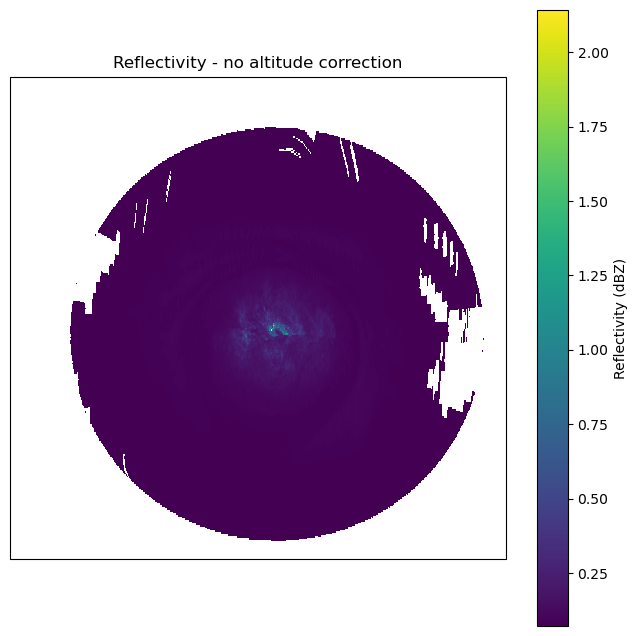

In [83]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())

ax.set_extent([2, 3, -72.15, -71.85], crs=ccrs.PlateCarree())
ax.coastlines()


cf = ax.pcolormesh(lon_target, lat_target, snowSort[:, :, 2], transform=ccrs.PlateCarree(), cmap='viridis')
plt.colorbar(cf, label='Reflectivity (dBZ)')
plt.title("Reflectivity - no altitude correction")

plt.show()